# HER Plots

The experiments create these outputs:
* runs
    * 

In [1]:
import json
import glob
import os
import numpy as np
from scipy.signal import medfilt

import argparse
from argparse import Namespace

import pandas as pd
import re

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
%matplotlib inline

/h/harris/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/h/harris/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [35]:
def smooth_reward_curve(x, y):
    halfwidth = min(31, int(np.ceil(len(x) / 30)))  # Halfwidth of our smoothing convolution
    k = halfwidth
    xsmoo = x[k:-k]
    ysmoo = np.convolve(y, np.ones(2 * k + 1), mode='valid') / np.convolve(np.ones_like(y), np.ones(2 * k + 1),
                                                                           mode='valid')
    downsample = max(int(np.floor(len(xsmoo) / 1e3)), 1)
    return xsmoo[::downsample], ysmoo[::downsample]


def fix_point(x, y, interval):
    np.insert(x, 0, 0)
    np.insert(y, 0, 0)

    fx, fy = [], []
    pointer = 0
    ninterval = int(max(x) / interval + 1)

    for i in range(ninterval):
        tmpx = interval * i

        while pointer + 1 < len(x) and tmpx > x[pointer + 1]:
            pointer += 1

        if pointer + 1 < len(x):
            alpha = (y[pointer + 1] - y[pointer]) / (x[pointer + 1] - x[pointer])
            tmpy = y[pointer] + alpha * (tmpx - x[pointer])
            fx.append(tmpx)
            fy.append(tmpy)

    return fx, fy


def load_data(indir, smooth, bin_size):
    datas = []
    infiles = glob.glob(os.path.join(indir, '*.csv'))
    datas_goal = []

    for inf in infiles:
        data = []
        data_csv = np.loadtxt(inf, delimiter=",", skiprows=1, usecols=[1,2])
        for sec, acc in zip(data_csv[:,0], data_csv[:,1]):
            data.append([sec, acc])
        datas.append(data)

    def process_data(datas):
        datas = sorted(datas, key=lambda d_entry: d_entry[0])
        result = []
        timesteps = 0
        for i in range(len(datas)):
            result.append([timesteps, datas[i][-1]])
            timesteps = datas[i][0]

        x, y = np.array(result)[:, 0], np.array(result)[:, 1]

        if smooth == 1:
            x, y = smooth_reward_curve(x, y)

        if smooth == 2:
            y = medfilt(y, kernel_size=9)

        x, y = fix_point(x, y, bin_size)
        return [x, y]
    
#     if goal:
#         return list(zip(*tuple([process_data(data_goal[goal]) for data_goal in datas_goal])))

#     else:
    return list(zip(*(process_data(data) for data in datas)))


def load(indir, smooth, bin_size, filts, goal=None, mode='train'):
    dirs = []
    for filt in filts:
        dirs += glob.glob(os.path.join(indir, '{}'.format(filt)))
    result = []

    for i in range(len(dirs)):
        tmpx, tmpy = [], []
        legend = dirs[i].strip('/').split('/')[-1]
        label = ""
        
        if "HER" in legend:
            label += "HER"
        
        if "LER" in legend:
            label += " + LER"
    
        tx, ty = load_data(dirs[i], smooth, bin_size)
        tmpx+=tx
        tmpy+=ty

        if len(tmpx) > 1:
            length = min([len(t) for t in tmpx])
            for j in range(len(tmpx)):
                tmpx[j] = tmpx[j][:length]
                tmpy[j] = tmpy[j][:length]

            x = np.mean(np.array(tmpx), axis=0)
            y_mean = np.mean(np.array(tmpy), axis=0)
            y_std = np.std(np.array(tmpy), axis=0)
        else:
            x = np.array(tmpx).reshape(-1)
            y_mean = np.array(tmpy).reshape(-1)
            y_std = np.zeros(len(y_mean))

        result.append([label, x, y_mean, y_std])
    return result

In [51]:

# color_defaults = [
#     '#1f77b4',  # muted blue
#     '#ff7f0e',  # safety orange
#     '#2ca02c',  # cooked asparagus green
#     '#d62728',  # brick red
#     '#9467bd',  # muted purple
#     '#8c564b',  # chestnut brown
#     '#e377c2',  # raspberry yogurt pink
#     '#7f7f7f',  # middle gray
#     '#bcbd22',  # curry yellow-green
#     '#17becf'  # blue-teal
# ]

parser = argparse.ArgumentParser(description="Run commands")
parser.add_argument('--folder', type=str, default="",
                    help="Folder with resuls", required=True)
parser.add_argument('--smooth', type=int, default=2,
                    help="Smooth with openai smoothing")
parser.add_argument('--bin_size', type=int, default=16,
                    help="bin size for average")
parser.add_argument('--outfile', type=str, default="",
                    help='outfile', required=True)
parser.add_argument('--mode', type=str, default="test",
                    help='Mode', required=False)

def plot(args):
    game = args.folder.strip('/').split('/')[-1]
    plt.figure(figsize=(4,3.5), dpi=200)
    datas = load(args.folder, args.smooth, args.bin_size, args.filters, args.goal, args.mode)
    lines = []
    max_y = args.max_y
    min_y = args.min_y
    max_x = args.max_x
    min_x = 1e10
    num_frames_per_timestep = 1 # Environment gives a frame every 5 frames 
    for i in range(len(datas)):
        label, x, y_mean, y_std = datas[i]
        x = x * args.num_processes * num_frames_per_timestep # For converting train to number of frames
        color = args.color_defaults[i]
        if np.sum(y_std):
            y_upper = y_mean + y_std
            y_lower = y_mean - y_std
            plt.fill_between(
                x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
            )
        if args.linestyles is not None:
            linestyle = args.linestyles[i]
            line = plt.plot(x, list(y_mean), label=label, color=color, linestyle=linestyle)
        else:
            line = plt.plot(x, list(y_mean), label=label, color=color)
        lines.append(line[0])
        if max(x) < min_x: min_x = max(x)


    plt.xticks(args.x_values, args.x_labels)
    plt.xlabel('Epoch', fontsize=14)
    if args.goal is None:
        plt.ylabel('Success Rate', fontsize=14)
    else:
        plt.ylabel(args.goal, fontsize=14)
    
    plt.ylim(min_y, max_y)
    plt.xlim(0, max_x)
    plt.legend(loc=args.legend_loc)
    plt.title(args.title, fontsize=14)
    plt.tight_layout(pad=0.0) # Make room for the xlabel
    plt.savefig(args.outfile, format='pdf', dpi=100) # Need to do savefig before plt.show() otherwise PDF file will be blank
    plt.show()
    plt.draw()
    

# Example Usage

Specify the folders where the results are stored

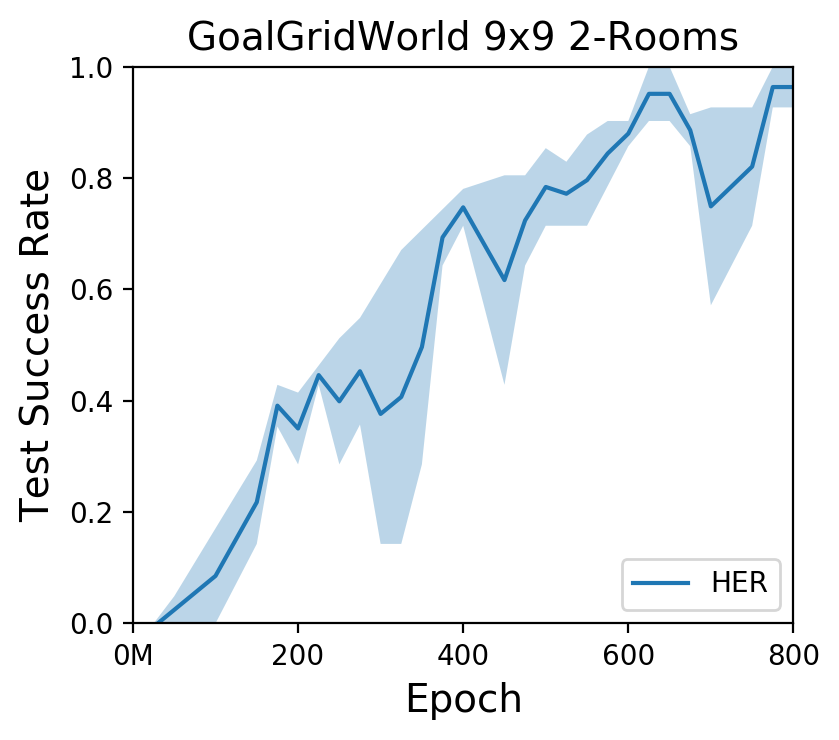

<Figure size 432x288 with 0 Axes>

In [52]:
# Part I
# Compositional Target
# ACTRCE vs Baseline
# Training thread
folder = "./GoalGridWorld/TestReward/"
smooth = 1
bin_size = 25
goal="Test Success Rate"
outfile = "figs/Vizdoom_easy_5obj_compositional_ICLR_Reach2Corr1.pdf"
mode = 'part1'
title = 'GoalGridWorld 9x9 2-Rooms'
num_proc = 1
x_values = [0, 2e2,4e2, 6e2,8e2]
x_labels = ["0M", "200","400","600","800"]
filters = [
            "debug_HER",
          ]

max_x = 0.8e3
max_y = 1.0
min_y = 0

color_defaults = [
    '#1f77b4',  # muted blue
#     '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
#     '#d62728',  # brick red
#     '#9467bd',  # muted purple
#     '#8c564b',  # chestnut brown
#     '#e377c2',  # raspberry yogurt pink
#     '#7f7f7f',  # middle gray
#     '#bcbd22',  # curry yellow-green
#     '#17becf'  # blue-teal
]

legend_loc='lower right' # or: lower_right

line_styles = None
args = Namespace(folder=folder, smooth=smooth, bin_size=bin_size, outfile=outfile, \
                 filters=filters, goal=goal, mode=mode, title=title, num_processes=num_proc, \
                 x_values=x_values, x_labels=x_labels, color_defaults=color_defaults, \
                 linestyles=line_styles, max_x=max_x, max_y=max_y,min_y=min_y,legend_loc=legend_loc
                )
plot(args)

## Cumulative Success Rate vs Episode Length 

* x-axis: episode length
* y-axis: (# successful episodes with length less than x)/(total number of episodes)

The intuition: Agents that are better should have a higher area under the curve (i.e. more shorter episodes...)


In [5]:
def plot_success_episode_len(args):
    print(args.folder)
    plt.figure(figsize=(4,3.5), dpi=200)
    
    for i in range(len(args.folder)):
        file = args.folder[i]
        legend_name = args.legend_names[i]
        color = args.color_defaults[i]
        
        filename = os.path.join(file, "eval1_seed1_episode_and_success_curve_1.csv")
        data = np.loadtxt(filename, delimiter=',',skiprows=1)
        eps_len = data[:,0]
        cum_success = data[:,1]
        cum_eps_len = data[:,2]
#         plt.plot(eps_len, cum_success, label=legend_name, color=color)
        plt.step(eps_len, cum_success, label=legend_name, color=color, where='post')
#         plt.plot(eps_len, cum_eps_len)
    
    plt.legend(loc="lower right")
    plt.title(args.title, fontsize=14)
#     plt.ylim(0,1)
    plt.xlabel("Episode Length", fontsize=14)
    plt.ylabel("Success Rate within Eps Len", fontsize=14)
    plt.tight_layout(pad=0.0) # Make room for the xlabel
    
    plt.savefig(args.outfile, format='pdf', dpi=100) # Need to do savefig before plt.show() otherwise PDF file will be blank
    plt.show()
    plt.draw()
    return
    
def plot_cum_episode_len(args):
    print(args.folder)
    plt.figure(figsize=(4,3.5), dpi=200)
    
    for i in range(len(args.folder)):
        file = args.folder[i]
        legend_name = args.legend_names[i]
        color = args.color_defaults[i]
        
        filename = os.path.join(file, "eval1_seed1_episode_and_success_curve_1.csv")
        data = np.loadtxt(filename, delimiter=',',skiprows=1)
        eps_len = data[:,0]
        cum_eps_len = data[:,2]
        plt.step(eps_len, cum_eps_len, label=legend_name, color=color, where='post')
#          plt.plot(eps_len, cum_eps_len, label=legend_name, color=color)
#         plt.plot(eps_len, cum_eps_len)
    
    plt.legend(loc="lower right")
    plt.title(args.title, fontsize=14)
    plt.xlabel("Episode Length", fontsize=14)
    plt.ylabel("Cumulative Dist Eps Len", fontsize=14)
    plt.tight_layout(pad=0.0) # Make room for the xlabel
    
    plt.savefig(args.outfile, format='pdf', dpi=100) # Need to do savefig before plt.show() otherwise PDF file will be blank
    plt.show()
    plt.draw()
    return
    

In [6]:
# 7 objects hard (single)
# title = "Cumulative Success vs. Episode Length\n(7 objects hard)"
title = "ViZDoom Single (7 objects hard)"
folders = [
            "./iclr_experiments/single_7obj_hard_anneal_exp_largeroom/gru_Time0.0/",        
            "./iclr_experiments/single_7obj_hard_anneal_exp_largeroom/gru_Time1.0/",
            "./saved_exp550_envsingle_Diffhard_numObj7_A3C_lr0.001_pt2/",
         ]

legend_names = ["DQN",
                "ACTRCE",
                "A3C"
               ]

outfile = "./figs/Vizdoom_hard_7obj_largeroom_ICLR_SuccVsEpsLen.pdf"
color_defaults = [
    '#1f77b4',  # muted blue
#     '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
#     '#d62728',  # brick red
#     '#9467bd',  # muted purple
#     '#8c564b',  # chestnut brown
#     '#e377c2',  # raspberry yogurt pink
#     '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
#     '#17becf'  # blue-teal
]

args = Namespace(folder=folders,
                 legend_names=legend_names,
                 color_defaults=color_defaults,
                 title=title,
                 outfile=outfile
                )
    
plot_success_episode_len(args)

args.outfile = "./figs/Vizdoom_hard_7obj_largeroom_ICLR_CumEpsVsEpsLen.pdf"
plot_cum_episode_len(args)

['./iclr_experiments/single_7obj_hard_anneal_exp_largeroom/gru_Time0.0/', './iclr_experiments/single_7obj_hard_anneal_exp_largeroom/gru_Time1.0/', './saved_exp550_envsingle_Diffhard_numObj7_A3C_lr0.001_pt2/']


OSError: ./iclr_experiments/single_7obj_hard_anneal_exp_largeroom/gru_Time0.0/eval1_seed1_episode_and_success_curve_1.csv not found.

<Figure size 800x700 with 0 Axes>

## Plot a histogram of the trajectory lengths



In [7]:
def plot_success_episode_len_hist(args):
    print(args.folder)
    plt.figure(figsize=(4,3.5), dpi=200)
    
    for i in range(len(args.folder)):
        file = args.folder[i]
        legend_name = args.legend_names[i]
        color = args.color_defaults[i]
        
        filename = os.path.join(file, "eval1_episode_and_success_pairs_sorted_1.csv")
        data = np.loadtxt(filename, delimiter=',',skiprows=1)
        eps_len = data[:,0]
        success = data[:,1]
        
        import pdb; pdb.set_trace()
        suc_indx = np.where(success == 1)
        plt.hist(eps_len[suc_indx],label=legend_name)
        
#         plt.plot(eps_len, cum_eps_len)
    
    plt.legend(loc="lower right")
    plt.title(args.title, fontsize=14)
    plt.xlabel("Episode Length", fontsize=14)
    plt.ylabel("Success Rate within Eps Len", fontsize=14)
    plt.tight_layout(pad=0.0) # Make room for the xlabel
    
    plt.savefig(args.outfile, format='pdf', dpi=100) # Need to do savefig before plt.show() otherwise PDF file will be blank
    plt.show()
    plt.draw()
    return
    